In [187]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [188]:
# Import data
driver_df = pd.read_csv("data/drivers.csv")
constructors_df = pd.read_csv("data/constructors.csv")
lap_times_df = pd.read_csv("data/lap_times.csv")
races_df = pd.read_csv("data/races.csv")
results_df = pd.read_csv("data/results.csv")

In [189]:
# Change the races_df to have a datetime index
races_df["date"] = pd.to_datetime(races_df["date"])
races_df = races_df.set_index("date")
races_df.head()

,raceId,year,round,circuitId,name,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
date,,,,,,,,,,,,,,,,,
2009-03-29,1,2009,1,1,Australian Grand Prix,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2009-04-05,2,2009,2,2,Malaysian Grand Prix,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2009-04-19,3,2009,3,17,Chinese Grand Prix,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2009-04-26,4,2009,4,3,Bahrain Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2009-05-10,5,2009,5,4,Spanish Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [190]:
# Create a dataframe with race ID and date. And a function to add the date as the index of other dataframes
id_date = pd.DataFrame()
id_date["raceId"] = races_df["raceId"]
id_date = id_date.reset_index()


def raceId_to_date(df):
    df = df.merge(id_date, how="left", on="raceId").set_index("date").sort_index()
    return df

In [200]:
# Function to look up driver id by their surname
def lookup_driver(name):
    return driver_df[driver_df["surname"] == name]

# Function to look up driver name by their ID
def lookup_driver_name(id):
    df = driver_df[driver_df["driverId"] == id]
    return df["surname"].item()

# Function to look up race id by a part of the name
def lookup_race(name):
    return races_df[races_df["name"].str.contains(name)]


# Function to look up laptimes from specific race and driver
def lookup_race_per_lap(race, driver):
    df = lap_times_df[lap_times_df["driverId"] == driver]
    df = df[df["raceId"] == race]
    df = df.set_index("lap").sort_index()
    return df


# Function to look up results from specific race and driver
def lookup_result(race, driver):
    df = results_df[results_df["driverId"] == driver]
    df = df[df["raceId"] == race]
    return df


# Function to look up results from specific race and driver
def lookup_constructor_result(race, constructor):
    df = results_df[results_df["constructorId"] == constructor]
    df = df[df["raceId"] == race]
    return df


# Function to look op the teammate at a race of a specific driver
def get_teammate(race, driver):
    teammate_id = 0
    teammate_id = list(
        lookup_constructor_result(
            race, lookup_result(race, driver)["constructorId"].item()
        )["driverId"]
    )
    teammate_id.remove(driver)
    if teammate_id:
        return teammate_id[0]
    else:
        return driver


# Plot the laptimes of a driver at a race and also those of his teammate
def plot_laptimes(race, driver):
    lookup_race_per_lap(race, driver)["milliseconds"].plot()
    lookup_race_per_lap(race, get_teammate(race, driver))["milliseconds"].plot()


# Get a result of a driver and his teammate of a certain race (f.e. "grid", "position")
def compare_result(race, driver, kind):
    own_result = lookup_result(race, driver)[kind].item()
    teammate_result = lookup_result(race, get_teammate(race, driver))[kind].item()
    return (own_result, teammate_result)


# Get a list of races which the driver participated in
def get_driver_races(driver):
    races_list = list(results_df[results_df["driverId"] == driver]["raceId"])
    return races_list

# Plot the personal results of a driver of a certain kind
def plot_personal_results(driver, kind, roll, plot):
    result_list = []
    for race in get_driver_races(driver):
        result_list.append(lookup_result(race, driver)[kind].item())

    career_df = (
        pd.DataFrame(
            data=result_list,
            index=get_driver_races(driver),
            columns=[kind],
        )
        .reset_index()
        .rename(columns={"index": "raceId"})
    )

    career_df = raceId_to_date(career_df)

    if plot:
        plt.plot(career_df[kind].rolling(roll).mean())
        plt.gca().invert_yaxis()
        plt.title(lookup_driver_name(driver) + " " + kind + " over career")
        plt.grid()
    return career_df


# Get all results of a certain kind of a driver and his teammate, and score the driver on his performance compared to his teammate
def compare_all_results(driver, kind, score_scale, roll, plot):
    result_list = []
    for race in get_driver_races(driver):
        result_list.append(compare_result(race, driver, kind))

    compare_df = (
        pd.DataFrame(
            data=result_list,
            index=get_driver_races(driver),
            columns=["own", "teammate"],
        )
        .reset_index()
        .rename(columns={"index": "raceId"})
    )

    compare_df = raceId_to_date(compare_df)
    compare_df["difference"] = compare_df["teammate"] - compare_df["own"]
    compare_df["noroll_score"] = (compare_df["difference"]) / (score_scale)
    compare_df["score"] = compare_df["noroll_score"].rolling(roll).mean()

    if plot:
        plt.plot(compare_df["score"])
        plt.gca().set_ylim([-1, 1])
        plt.title(lookup_driver_name(driver) + " " + kind + " against Teammates over career")
        plt.grid()
    return compare_df


def average(list):
    return sum(list) / len(list)

In [192]:
# Change the results dataframe and laptime dataframe to have a date as the index, and also clean up missing data from the results dataframe
#results_df = raceId_to_date(results_df)


results_df = results_df.replace({"\\N": 20})


#lap_times_df = raceId_to_date(lap_times_df)

<Axes: xlabel='date'>

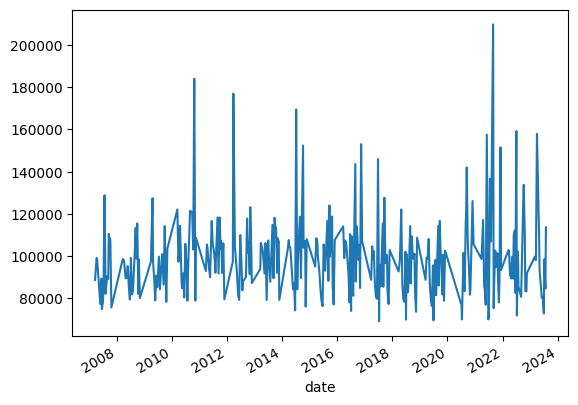

In [193]:
# Generates a graph with laptimes over some drivers whole career
# Not really interesting data, but graph is used for testing the change from race ID to date
lap_times_df = raceId_to_date(lap_times_df)
lap_times_df[lap_times_df["driverId"] == 1].groupby("date")[
    "milliseconds"
].mean().plot()

<Axes: xlabel='date'>

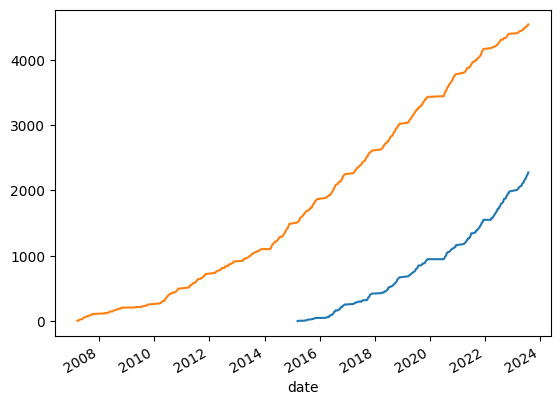

In [194]:
# Plots the cumulative career points of two drivers, again for testing if the raceid to date function works
results_df[results_df["driverId"] == 830]["points"].cumsum().plot()
results_df[results_df["driverId"] == 1]["points"].cumsum().plot()

In [179]:
# Easily lookup driver information by their surname
display(lookup_driver("Verstappen"))

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
49,50,verstappen,\N,\N,Jos,Verstappen,1972-03-04,Dutch,http://en.wikipedia.org/wiki/Jos_Verstappen
829,830,max_verstappen,33,VER,Max,Verstappen,1997-09-30,Dutch,http://en.wikipedia.org/wiki/Max_Verstappen


In [180]:
# Easily lookup race information by a part of it's name
display(lookup_race("Dutch").tail())

,raceId,year,round,circuitId,name,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
date,,,,,,,,,,,,,,,,,
1953-06-07,810,1953,3,39,Dutch Grand Prix,\N,http://en.wikipedia.org/wiki/1953_Dutch_Grand_...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1952-08-17,823,1952,7,39,Dutch Grand Prix,\N,http://en.wikipedia.org/wiki/1952_Dutch_Grand_...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2021-09-05,1064,2021,13,39,Dutch Grand Prix,13:00:00,http://en.wikipedia.org/wiki/2021_Dutch_Grand_...,2021-09-03,\N,2021-09-03,\N,2021-09-04,\N,2021-09-04,\N,\N,\N
2022-09-04,1088,2022,15,39,Dutch Grand Prix,13:00:00,http://en.wikipedia.org/wiki/2022_Dutch_Grand_...,2022-09-02,10:30:00,2022-09-02,14:00:00,2022-09-03,10:00:00,2022-09-03,13:00:00,\N,\N
2023-08-27,1111,2023,13,39,Dutch Grand Prix,13:00:00,https://en.wikipedia.org/wiki/2023_Dutch_Grand...,2023-08-25,10:30:00,2023-08-25,14:00:00,2023-08-26,09:30:00,2023-08-26,13:00:00,\N,\N


<Axes: xlabel='lap'>

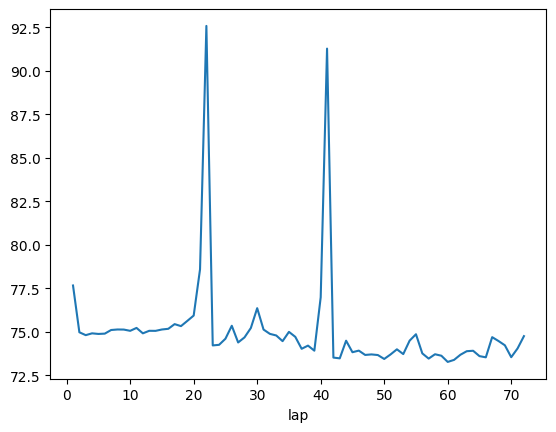

In [203]:
# Lookup driver information during a race
max_dutchgp_2021 = lookup_race_per_lap(1064, 830)
(max_dutchgp_2021["milliseconds"] / 1000).plot()

<Axes: xlabel='lap'>

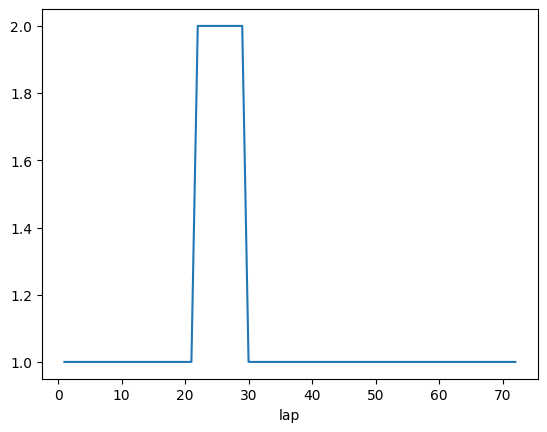

In [182]:
# You can also plot a drivers position
max_dutchgp_2021["position"].plot()

In [183]:
# Lookup the result of a driver at a race
lookup_result(1064, 830)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
date,,,,,,,,,,,,,,,,,,
2021-09-05,25206,1064,830,9,33,1,1,1,1,25.0,72,1:30:05.395,5405395,60,3,1:13.275,209.244,1


In [184]:
# Lookup the result of a constructor at a race
lookup_constructor_result(1064, 9)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
date,,,,,,,,,,,,,,,,,,
2021-09-05,25206,1064,830,9,33,1,1,1,1,25.0,72,1:30:05.395,5405395,60,3,1:13.275,209.244,1
2021-09-05,25213,1064,815,9,11,0,8,8,8,4.0,71,20,20,59,4,1:13.461,208.714,11


In [185]:
# Lookup a teammate of a driver at a certain race
get_teammate(1064, 830)

815

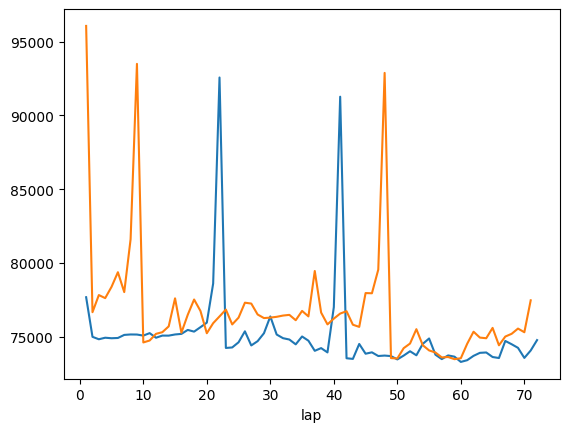

In [167]:
# Plot the laptimes of a driver and their teammate at a certain race
plot_laptimes(1064, 830)

In [168]:
# Compare a result of your choice of a driver with his teammate at a race
compare_result(1064, 830, "positionOrder") 

(1, 8)

In [169]:
# Get a list of all races a driver competed in
get_driver_races(830)

[926,
 927,
 928,
 929,
 930,
 931,
 932,
 933,
 934,
 936,
 937,
 938,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 948,
 949,
 950,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 960,
 961,
 962,
 963,
 964,
 965,
 966,
 967,
 968,
 969,
 970,
 971,
 972,
 973,
 974,
 975,
 976,
 977,
 978,
 979,
 980,
 981,
 982,
 983,
 984,
 985,
 986,
 987,
 988,
 989,
 990,
 991,
 992,
 993,
 994,
 995,
 996,
 997,
 998,
 999,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1022,
 1023,
 1024,
 1025,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1059,
 1058,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1069,
 1070,
 1071,
 1051,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1078,
 1079,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,


,raceId,positionOrder
date,,
2015-03-15,926,13
2015-03-29,927,7
2015-04-12,928,17
2015-04-19,929,18
2015-05-10,930,11
...,...,...
2023-06-18,1106,1
2023-07-02,1107,1
2023-07-09,1108,1


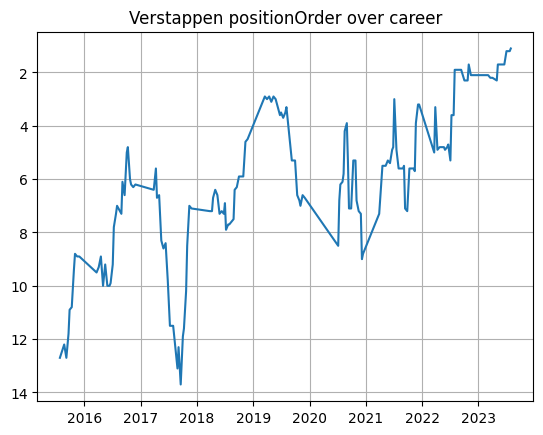

In [202]:
# Plot a certain result of a driver over his career
plot_personal_results(830, "positionOrder", 10, True)

,raceId,own,teammate,difference,minus,noroll_score,score
date,,,,,,,
2015-03-15,926,13,9,-4,-1.0,-0.210526,NaN
2015-03-29,927,7,8,1,1.0,0.052632,NaN
2015-04-12,928,17,13,-4,-1.0,-0.210526,NaN
2015-04-19,929,18,19,1,1.0,0.052632,NaN
2015-05-10,930,11,9,-2,-1.0,-0.105263,NaN
...,...,...,...,...,...,...,...
2023-06-18,1106,1,6,5,1.0,0.263158,0.157895
2023-07-02,1107,1,3,2,1.0,0.105263,0.163158
2023-07-09,1108,1,6,5,1.0,0.263158,0.178947


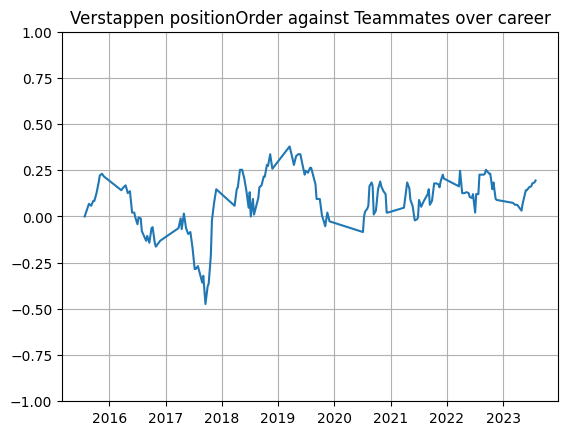

In [201]:
# Plot a drivers results compared to his teammate over his career
# compare_all_results(driver, what to compare, score scale, moving avarage lenght, plot)
compare_all_results(830, "positionOrder", 19, 10, True)

From here on the analysing of the drivers before retirement starts


In [103]:
# Get a list of all drivers, and then remove all drivers who have not yet retired
driver_list = list(results_df["driverId"].unique())

for driver in list(results_df.loc["2023"]["driverId"].unique()):
    driver_list.remove(driver)

  0%|          | 0/836 [00:00<?, ?it/s]

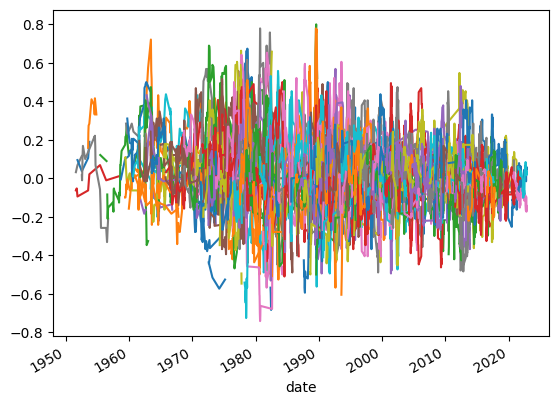

In [104]:
# Generate a graph which shows the performance of all drivers against their teammates
result = []

fig, ax = plt.subplots()

for driver in tqdm(driver_list):
    try:
        temp_result = compare_all_results(driver, "positionOrder", 19, 10, False)
        result.append(temp_result)
        temp_result["score"].plot(ax=ax)
    except:
        pass

plt.show()

In [113]:
# Calculate the average score of drivers in their last races
final_races_mean = []
FINAL_RACE_AMOUNT = 10

for i in range(1, FINAL_RACE_AMOUNT + 1):
    for df in result:
        temp_final_races_mean = []
        df = df.fillna(0)
        temp_final_races_mean = temp_final_races_mean + list(df["noroll_score"].tail(i))
    final_races_mean.append(average(temp_final_races_mean))

In [117]:
# Print the average score and the average positions higher/lower than their teammates
print("Average score final 10 races:  " + str(round(final_races_mean[9], 5)))
print("Positions higher/lower than teammate:  " + str((final_races_mean[9] * 19)))

Average score final 10 races:  -0.03684
Positions higher/lower than teammate:  -0.7


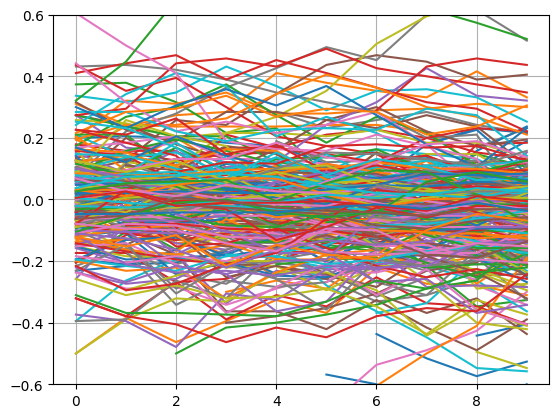

In [110]:
# Plot the final 10 races of all drivers
fig2, ax2 = plt.subplots()

for df in result:
    df.tail(10).reset_index()["score"].plot(ax=ax2)

fig2 = plt.gca().set_ylim([-0.6, 0.6])
fig2 = plt.grid()

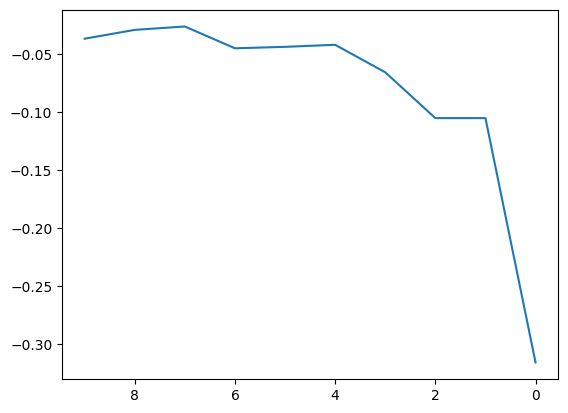

In [ ]:
# Plot the average over the final races
plt.plot(final_races_mean)
plt.gca().invert_xaxis()